In [14]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.io import loadmat
import visionloader as vl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import src.fitting as fitting
import src.multielec_utils as mutils
from mpl_toolkits.mplot3d import Axes3D
import gpytorch
import torch

%load_ext autoreload
%autoreload 2
%matplotlib ipympl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load in triplet stim elecResps and amplitudes

In [2]:
ANALYSIS_BASE = "/Volumes/Analysis"
gsort_path = "/Volumes/Scratch/Users/praful/triplet_gsort_v2_30um_periphery-affinity_cosine"

In [3]:
dataset = "2020-10-18-5"
estim = "data006/data006-all_v2"
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim)

In [4]:
wnoise = "kilosort_data002/data002"
vis_datapath = os.path.join(ANALYSIS_BASE, dataset, wnoise)
vis_datarun = wnoise.split('/')[-1]
vcd = vl.load_vision_data(
    vis_datapath,
    vis_datarun,
    include_neurons=True,
    include_ei=True,
    include_params=True,
    include_noise=True,
)

coords = vcd.get_electrode_map()

In [5]:
p = 2
n = 220

p_thr = 2/19
p_upper = 1
random_state = 0

In [6]:
filepath = os.path.join(gsort_path, 
                        dataset, estim, wnoise, "p" + str(p))

triplet_elecs = mutils.get_stim_elecs_newlv(electrical_path, p)
amplitudes = mutils.get_stim_amps_newlv(electrical_path, p)

num_pts = len(amplitudes)

triplet_probs = torch.zeros(num_pts)
for k in range(num_pts):
    with open(os.path.join(filepath, "gsort_tri_v2_n" + str(n) + "_p" + str(p) + "_k" + str(k) + ".pkl"), "rb") as f:
        prob_dict = pickle.load(f)
        triplet_probs[k] = prob_dict["cosine_prob"][0]

good_inds = np.where((triplet_probs > p_thr) & (triplet_probs < p_upper))[0]

In [9]:
len(good_inds)

2078

/tmp/ipykernel_29021/1297822682.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


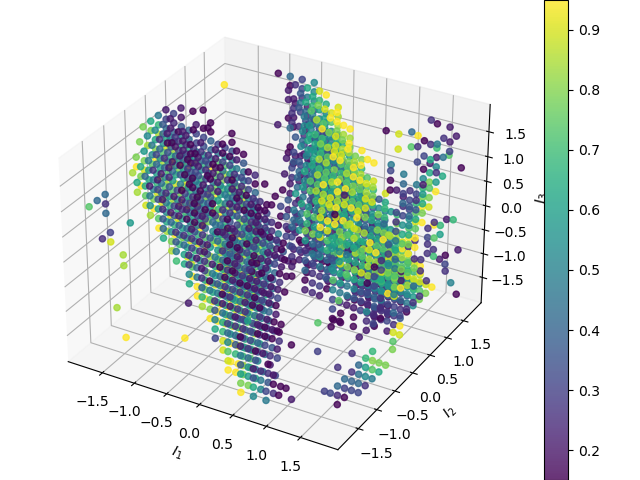

In [10]:
fig = plt.figure(0)
fig.clear()
ax = Axes3D(fig)
plt.xlabel(r'$I_1$')
plt.ylabel(r'$I_2$')
ax.set_zlabel(r'$I_3$')

scat = ax.scatter(amplitudes[:, 0][good_inds], 
            amplitudes[:, 1][good_inds],
            amplitudes[:, 2][good_inds], marker='o', s=20, c=triplet_probs[good_inds], alpha=0.8)

clb = plt.colorbar(scat)
plt.show()

In [13]:
test_size = 0.2
train_amps, test_amps, train_probs, test_probs = train_test_split(amplitudes[good_inds], triplet_probs[good_inds], test_size=test_size)

In [ ]:
# A GP model with constant mean function and spectral mixture (SM) kernel
class SpectralMixtureGP(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, likelihood):
        super(SpectralMixtureGP, self).__init__(x_train, y_train, likelihood)
        self.mean = gpytorch.means.ConstantMean() # Construct the mean function
        self.cov = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4) # Construct the kernel function
        self.cov.initialize_from_data(x_train, y_train) # Initialize the hyperparameters from data
        
    def forward(self, x):
        # Evaluate the mean and kernel function at x
        mean_x = self.mean(x)
        cov_x = self.cov(x)
        # Return the multivariate normal distribution using the evaluated mean and kernel function
        return gpytorch.distributions.MultivariateNormal(mean_x, cov_x) 
        
# Initialize the likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = SpectralMixtureGP(train_amps, train_probs, likelihood)